We try to fit different scaling law functional forms to empirical scaling data

### Load libraries

In [42]:
import os
import pathlib
import sys
from typing import Any, Optional

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import torch
from torch import nn
import wandb
import wandb.apis.public
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

from src import utils

### Load empirical scaling data

In [2]:
api = wandb.Api(timeout=30)
runs: list[wandb.apis.public.Run] = api.runs(
    f"data-frugal-learning/probe-embeddings",
    filters={
        "$and": [
            {"tags": {"$in": ["probe-seeds-v1"]}},
            {"config.dataset_cfg.id": {"$eq": "cifar10"}},
        ]
    },
)


def get_df_from_run(
    run_id: str,
    run_config: dict[str, Any],
    run_summary: dict[str, Any],
) -> pd.DataFrame:
    api = wandb.Api(timeout=30)
    artifact = api.artifact(
        f"data-frugal-learning/probe-embeddings/run-{run_id}-df_scaling:v0",
    )
    ret_df = utils.artifact_to_df(artifact)

    ret_df["dataset_id"] = run_config["dataset_cfg"]["id"]
    ret_df["embedder_id"] = run_config["embedder_cfg"]["id"]
    ret_df["embed_dim"] = run_summary["embed_dim"]
    ret_df["n_embedder_params"] = run_summary["n_embedder_params"]
    ret_df["seed"] = run_config["seed"]

    for i in range(10):
        ret_df[f"err_{i}"] = 1 - ret_df[f"acc_{i}"]

    return ret_df


dfs = process_map(
    get_df_from_run,
    [r.id for r in runs],
    [dict(r.config) for r in runs],
    [
        {k: r.summary[k] for k in ("embed_dim", "n_embedder_params")}
        for r in runs
    ],
    max_workers=15,  # https://docs.wandb.ai/guides/track/limits
    tqdm_class=tqdm,
)
df = pd.concat(dfs, ignore_index=True)
df["model"] = df["embedder_id"]
df["model_type"] = df["embedder_id"].apply(
    lambda x: x.split("-")[0] if x.startswith("hf/") else x[:9],
)
df

100%|██████████| 500/500 [00:28<00:00, 17.41it/s]


,c,max_iter,seed,use_gpu,acc,xent,n_train,per_class,probe,cls_start,...,err_2,err_3,err_4,err_5,err_6,err_7,err_8,err_9,model,model_type
0,0.01,10000.0,49,True,0.1000,inf,1,False,linear,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openai/ViT-B/16,openai/Vi
1,1.00,10000.0,49,True,0.1000,inf,1,False,linear,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openai/ViT-B/16,openai/Vi
2,100.00,10000.0,49,True,0.1000,inf,1,False,linear,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openai/ViT-B/16,openai/Vi
3,NaN,NaN,49,True,0.1826,NaN,2,False,knn,0,...,1.000,1.000,0.062,1.000,1.000,1.000,1.000,0.112,openai/ViT-B/16,openai/Vi
4,0.01,10000.0,49,True,0.1826,inf,2,False,linear,0,...,1.000,1.000,0.062,1.000,1.000,1.000,1.000,0.112,openai/ViT-B/16,openai/Vi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211495,NaN,NaN,0,True,0.9832,NaN,5000,True,knn,0,...,0.017,0.059,0.017,0.015,0.005,0.008,0.002,0.011,hf/microsoft/beit-large-patch16-224,hf/microsoft/beit
211496,NaN,NaN,0,True,0.9819,NaN,5000,True,knn,0,...,0.016,0.061,0.018,0.015,0.005,0.007,0.002,0.016,hf/microsoft/beit-large-patch16-224,hf/microsoft/beit
211497,0.01,10000.0,0,True,0.9870,0.073968,5000,True,linear,0,...,0.013,0.025,0.012,0.032,0.010,0.006,0.006,0.011,hf/microsoft/beit-large-patch16-224,hf/microsoft/beit
211498,1.00,10000.0,0,True,0.9858,inf,5000,True,linear,0,...,0.014,0.030,0.014,0.033,0.011,0.004,0.008,0.011,hf/microsoft/beit-large-patch16-224,hf/microsoft/beit


### Define functional forms

In [43]:
class BasicPowerLaw(nn.Module):
    """
    L(n_param, n_train) = e^a0 * n_param^{-a1} + e^b0 * n_train^{-b1} + e^c
    """

    def __init__(
        self,
        a0: float,
        a1: float,
        b0: float,
        b1: float,
        c: float,
    ):
        super().__init__()
        self.a0 = nn.Parameter(torch.tensor(a0, dtype=torch.float32))  # type: ignore
        self.a1 = nn.Parameter(torch.tensor(a1, dtype=torch.float32))  # type: ignore
        self.b0 = nn.Parameter(torch.tensor(b0, dtype=torch.float32))  # type: ignore
        self.b1 = nn.Parameter(torch.tensor(b1, dtype=torch.float32))  # type: ignore
        self.c = nn.Parameter(torch.tensor(c, dtype=torch.float32))  # type: ignore

    def forward(
        self,
        n_params: torch.Tensor,
        n_trains: torch.Tensor,
    ) -> torch.Tensor:
        """Returns log L(n_params, n_trains)"""

        return torch.logsumexp(
            torch.stack(
                (
                    self.a0 - self.a1 * torch.log(n_params),
                    self.b0 - self.b1 * torch.log(n_trains),
                    0 * n_params + self.c,
                )
            ),
            dim=0,
        )


In [70]:
class InterpPowerLaw(nn.Module):
    """
    L_interp(n_param, n_train) =
        e^eps0
        * L_base(n_param, n_train)
        / sqrt(L_base(n_param, n_train)^2 + e^gamma)

    This is equivalent to the functional form in
    https://arxiv.org/pdf/1909.12673.pdf.
    """

    def __init__(
        self,
        base_power_law: BasicPowerLaw,
        eps0: float,
        gamma: float,
    ):
        super().__init__()
        self.base_power_law = base_power_law
        self.eps0 = nn.Parameter(torch.tensor(eps0, dtype=torch.float32))  # type: ignore
        self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32))  # type: ignore

    def forward(
        self,
        n_params: torch.Tensor,
        n_trains: torch.Tensor,
    ) -> torch.Tensor:
        """Returns log L_interp(n_params, n_trains)"""

        log_base = self.base_power_law(n_params, n_trains)
        return (
            self.eps0
            + log_base
            - 0.5
            * torch.logsumexp(
                torch.stack((2 * log_base, self.gamma + n_params * 0)), dim=0
            )
        )


In [94]:
class GaussianLaw(nn.Module):
    """
    L_interp(n_param, n_train) = Phi(
        - e^s
        / sqrt(
            1 + e^{-2s} * n_param /
                (e^b0 * n_train^{b1})
        )
    )
    """

    def __init__(
        self,
        s: float,
        b0: float,
        b1: float,
    ):
        super().__init__()
        self.s = nn.Parameter(torch.tensor(s, dtype=torch.float32))  # type: ignore
        self.b0 = nn.Parameter(torch.tensor(b0, dtype=torch.float32))  # type: ignore
        self.b1 = nn.Parameter(torch.tensor(b1, dtype=torch.float32))  # type: ignore

    def forward(
        self,
        n_params: torch.Tensor,
        n_trains: torch.Tensor,
    ) -> torch.Tensor:
        """Returns log L_interp(n_params, n_trains)"""

        return torch.special.log_ndtr(
            -torch.exp(self.s)
            / torch.sqrt(
                1
                + n_params
                * torch.exp(
                    -2 * self.s - self.b0 - self.b1 * torch.log(n_trains)
                )
            )
        )


### Fit some power laws

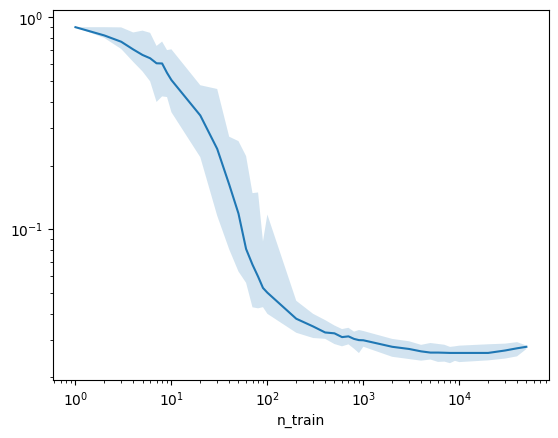

In [95]:
# embedder_id = "hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
embedder_id = "openai/ViT-L/14"
gb = df.query(
    "&".join(
        (
            "dataset_id == 'cifar10'",
            "cls_start == 0",
            "cls_end == 10",
            "(c == 100 | k == 1)",
            "embedder_id == @embedder_id",
            "probe == 'linear'",
            "per_class == False",
        )
    )
).groupby(["n_train"])

def plot_empirical_law():
    target="err"
    ci=0.99
    ax = gb[target].median().plot()
    prev_color = ax.lines[-1].get_color()
    plt.fill_between(
        gb[target].median().index,
        gb[target].quantile(0.5 - ci / 2),
        gb[target].quantile(0.5 + ci / 2),
        alpha=0.2,
        color=prev_color,
        edgecolor="none",
        zorder=ax.lines[-1].get_zorder() - 1,
    )
    plt.xscale("log")
    plt.yscale("log")

plot_empirical_law()

In [96]:
def fit_law(
    model: nn.Module,
    n_params: np.ndarray,
    n_trains: np.ndarray,
    errs: np.ndarray,
    max_iters: int = 20,
    huber_delta: float = 1e-3,
    show_progress: bool = False,
):
    n_params_t = torch.tensor(n_params)
    n_trains_t = torch.tensor(n_trains)
    errs_t = torch.tensor(errs)

    # Optimize model using LBFGS
    optimizer = torch.optim.LBFGS(
        model.parameters(),
        lr=0.8,
        max_iter=max_iters,
    )

    def closure():
        optimizer.zero_grad()
        pred_log_errs = model(n_params=n_params_t, n_trains=n_trains_t)
        loss = nn.functional.huber_loss(
            pred_log_errs,
            torch.log(errs_t),
            reduction="mean",
            delta=huber_delta,
        )
        loss.backward()
        return loss

    losses = []
    pbar = tqdm(range(max_iters), disable=not show_progress)
    for i in pbar:
        loss = optimizer.step(closure)  # type: ignore

        losses.append(loss.item())  # type: ignore
        pbar.set_description(f"Loss: {loss.item():.4e}")  # type: ignore

    return model, np.array(losses)


fit_law(
    InterpPowerLaw(BasicPowerLaw(0, 0, 0, 0, 0), 0, 0),
    n_params=gb.n_embedder_params.median().values,  # type: ignore
    n_trains=gb.n_train.median().values,  # type: ignore
    errs=gb.err.median().values,  # type: ignore
    show_progress=True,
)[-1][-1]


Loss: 1.0658e-03: 100%|██████████| 20/20 [00:00<00:00, 217.26it/s]


0.0010657862198918079

In [98]:
np.random.seed(42)
N_RANDOM_INITS = 222

n_params = gb.n_embedder_params.median().values
n_trains = gb.n_train.median().values
errs = gb.err.median().values

min_loss = np.inf
best_losses: Optional[np.ndarray] = None
best_model: Optional[nn.Module] = None

pbar = tqdm(range(N_RANDOM_INITS))
for _ in pbar:
    # Randomly initialize model
    # params = np.random.uniform(-5, 5, size=5)
    # model = BasicPowerLaw(*params)
    # params = np.random.uniform(-5, 5, size=7)
    # model = InterpPowerLaw(BasicPowerLaw(*params[:5]), *params[5:])
    params = np.random.uniform(-8, 8, size=2)
    model = GaussianLaw(*params)

    model, losses = fit_law(
        model=model, n_params=n_params, n_trains=n_trains, errs=errs
    )
    if losses[-1] < min_loss:
        min_loss = losses[-1]
        best_model = model
        best_losses = losses

    pbar.set_description(f"Loss: {min_loss:.4e}")


Loss: 1.9469e-03: 100%|██████████| 222/222 [00:08<00:00, 24.94it/s]


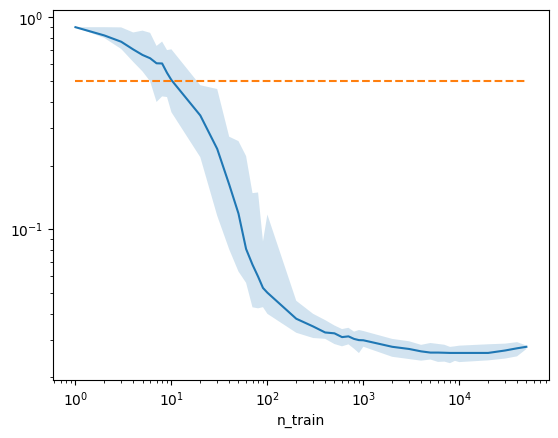

In [99]:
assert best_model is not None
pred_log_errs = best_model(
    n_params=torch.tensor(n_params),
    n_trains=torch.tensor(n_trains),
)
pred_errs = torch.exp(pred_log_errs).detach().numpy()

plot_empirical_law()
plt.plot(n_trains, pred_errs, linestyle="--")
plt.xscale("log")
plt.yscale("log")
